## Getting data from the full dataset via: CAVEclient('minnie65_public')

In [7]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils, skeletonize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from caveclient import CAVEclient
import meshparty.skeleton_io

In [5]:
def plot_sk_or_mesh(sk_or_mesh, in_3d=True, sample=50, soma=None, syn_list=None, syn_size=1,
                    ex_syn=None, inh_syn=None):
    if in_3d:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')

        if soma is not None:
            ax.scatter3D(soma[0], soma[1], soma[2], c='red', s=200, alpha=1, label='soma')
        if syn_list is not None:
            ax.scatter3D(syn_list[:,0], syn_list[:,1], syn_list[:,2], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter3D(ex_syn[:,0], ex_syn[:,1], ex_syn[:,2], c='green', s=syn_size, alpha=.8, label='ex syn')
        if inh_syn is not None:
            ax.scatter3D(inh_syn[:,0], inh_syn[:,1], inh_syn[:,2], c='purple', s=syn_size, alpha=.8, label='in syn')
        
        ax.scatter3D(sk_or_mesh.vertices[::sample,0],
                     sk_or_mesh.vertices[::sample,1],
                     sk_or_mesh.vertices[::sample,2], s=0.8, alpha=.5, label='mesh/sk')
    else: 
        f,ax = plt.subplots(figsize=(8,8))
        ax.scatter(sk_or_mesh.vertices[::sample,0], sk_or_mesh.vertices[::sample,1], s=1, alpha=.2, label='mesh/sk')
    
        if soma is not None:
            ax.scatter(soma[0], soma[1], c='red', s=100, alpha=0.9, label='soma')
        if syn_list is not None:
            ax.scatter(syn_list[:,0], syn_list[:,1], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter(ex_syn[:,0], ex_syn[:,1], c='green', s=syn_size, alpha=.9, label='ex syn')
        if inh_syn is not None:
            ax.scatter(inh_syn[:,0], inh_syn[:,1], c='purple', s=syn_size, alpha=.9, label='inh syn')
            
        ax.set_aspect('equal')
        ax.set_ylim(np.max(sk_or_mesh.vertices[:,1]), np.min(sk_or_mesh.vertices[:,1]))

    lgnd = plt.legend(scatterpoints=1)
    for handle in lgnd.legend_handles:
        handle.set_sizes([50.0])

In [13]:
some_id = 864691135207734905 # a root id from aibs_metamodel_mtypes_v661_v2	table

In [6]:
# the full dataset
client = CAVEclient('minnie65_public')

# Download mesh
mm = trimesh_io.MeshMeta(
  cv_path=client.info.segmentation_source(),
  disk_cache_path="data",
)

mesh = mm.mesh(seg_id=some_id, remove_duplicate_vertices=True)
mesh.vertices.shape

(349302, 3)

In [8]:
# Download skeleton
sk_dict = client.skeleton.get_skeleton(some_id, output_format='json')
sk_dict.keys()

sk = meshparty.skeleton.Skeleton(
    vertices=np.array(sk_dict['vertices']),
    edges=np.array(sk_dict['edges']),
    mesh_to_skel_map=sk_dict['mesh_to_skel_map'],
    vertex_properties=sk_dict['vertex_properties'],
    root=sk_dict['root'],
    meta=sk_dict['meta'],
)
print(sk.vertices.shape)

(401, 3)


In [9]:
# Calcualte skeleton based on the mesh
sk_calculated = skeletonize.skeletonize_mesh(mesh, invalidation_d=12000)
print(type(sk_calculated))
print(sk_calculated.vertices.shape)

C:\Users\dean\Documents\dev\Connectomics\OFS-EM-Connectomics\.venv\lib\site-packages\meshparty\skeletonize.py:622: RuntimeWarning: invalid value encountered in multiply
  target = np.nanargmax(root_ds * valid)


<class 'meshparty.skeleton.Skeleton'>
(8425, 3)


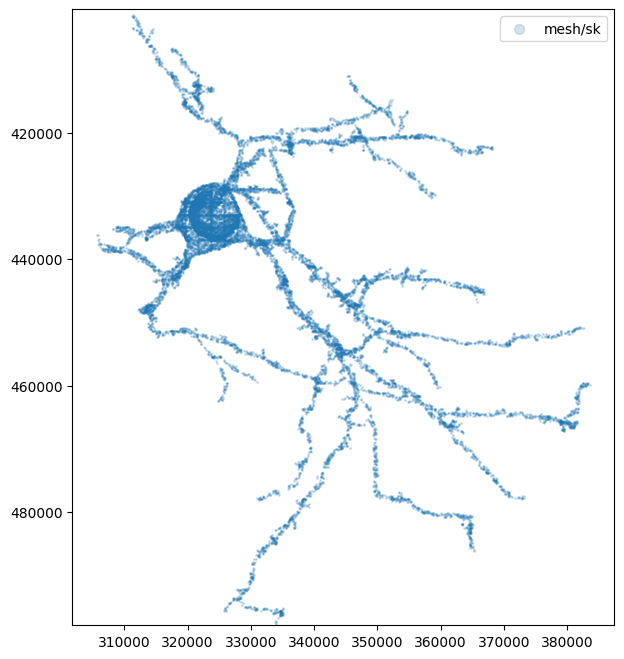

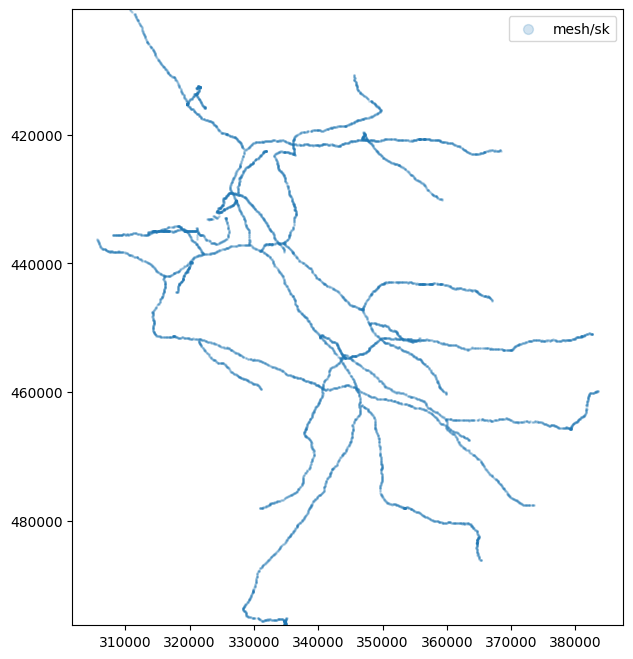

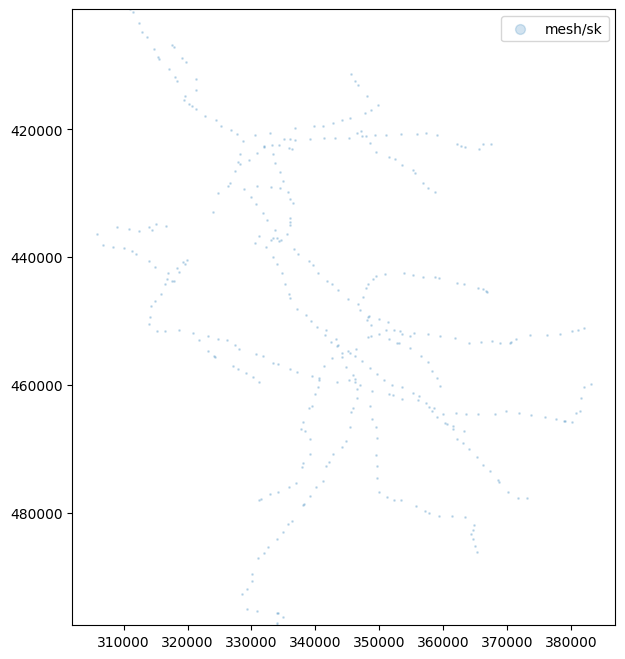

In [11]:
plot_sk_or_mesh(mesh, in_3d=False, sample=20)
plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1)
plot_sk_or_mesh(sk, in_3d=False, sample=1)
